## Import packages

In [1]:
import numpy as np
import pandas as pd
import gc, random, math, time

In [2]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten, Lambda, Permute
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate, Concatenate, multiply, Dot
from keras.layers import  GlobalMaxPooling1D, GlobalAveragePooling1D, Input, SpatialDropout1D, Bidirectional
from keras.layers import CuDNNLSTM, CuDNNGRU, LSTM, GRU, Softmax
from keras import backend as K
from keras.engine.topology import Layer
from keras.preprocessing import sequence, text
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import KFold

## Hyper parameter setting

In [4]:
embed_size = 300 # how big is each word vector
max_features = 160000 # how many unique words to use (i.e num rows in embedding vector)
maxlen_p = 150 # max number of words in a context to use
maxlen_q = 10 # max number of words in a question to use
batch_size = 256
num_rnn_units = 128
num_hidden_units = 300
drop_prob = 0.5
max_norm = 5.0
features = 2

## File path

In [5]:
train_path = './data/train.tsv' # train set
valid_path = './data/valid.tsv' # validation set
test_path = './data/test.tsv' # test set
embed_file = './sgns.target.word-ngram.1-2.dynwin5.thr10.neg5.dim300.iter5' # 预训练词向量
fasttext_file = './cc.zh.300.vec' # 预训练词向量
train_feature_path = './data/train_fea.npy' # train passage word feature
valid_feature_path = './data/valid_fea.npy' # validation passage word feature
test_feature_path = './data/test_fea.npy' # test passage word feature

##  Read file

In [6]:
train = pd.read_csv(train_path, sep='\t', header=0)
valid = pd.read_csv(valid_path, sep='\t', header=0)
test = pd.read_csv(test_path, sep='\t', header=0)
print (train.shape, valid.shape, test.shape)
print (train.head())

(750000, 5) (90000, 5) (29997, 4)
   id                                            passage  \
0   1  孩子 是 父母 的 一面镜子   由于 儿童 的 世界观 尚未 形成   他们 的 模仿 带...   
1   1  孩子 是 父母 的 一面镜子   由于 儿童 的   尚未 形成     的   带有 很大...   
2   1  孩子 是 父母 的 一面镜子   由于 儿童 的 世界观 尚未 形成     的 模仿 带有...   
3   2  目前   中国 很多     学生   磁条 都 已经 升级 了   在 磁条     写入...   
4   2  目前   中国 很多 地方   学生 火车票 磁条 都 已经 升级 了   在 磁条 里 已...   

                   query option  label  
0   你 的 孩子 无法确定 保姆 带 大 的   无法确定      1  
1      你 的 孩子 是 保姆 带 大 的      是      0  
2     你 的 孩子 不是 保姆 带 大 的     不是      0  
3  不是 一个 区间 刷 学生证 不能 有 票     不能      1  
4   不是 一个 区间 刷 学生证 能 有 票      能      0  


In [7]:
train_feature = np.load(train_feature_path)
valid_feature = np.load(valid_feature_path)
test_feature = np.load(test_feature_path)
print (train_feature.shape, valid_feature.shape, test_feature.shape)

(750000, 150, 2) (90000, 150, 2) (29997, 150, 2)


## Buld up the text input pipeline

####  Fit the tokenizer on train, valid and test set

In [8]:
tokenizer = Tokenizer(num_words=max_features, lower=True) 

tokenizer.fit_on_texts(pd.concat([train['passage'], train['query'], valid['passage'], valid['query'], test['passage'], test['query']], ignore_index=True))

In [9]:
print (tokenizer.document_count, len(tokenizer.word_counts))

1739994 172760


#### text to seq

In [10]:
tra_p = tokenizer.texts_to_sequences(train['passage'])
tra_q = tokenizer.texts_to_sequences(train['query'])
val_p = tokenizer.texts_to_sequences(valid['passage'])
val_q = tokenizer.texts_to_sequences(valid['query'])
te_p = tokenizer.texts_to_sequences(test['passage'])
te_q = tokenizer.texts_to_sequences(test['query'])

#### pad seq to maxlen

In [11]:
train_p = pad_sequences(tra_p, maxlen=maxlen_p)
train_q = pad_sequences(tra_q, maxlen=maxlen_q, padding='post', truncating='post')
valid_p = pad_sequences(val_p, maxlen=maxlen_p)
valid_q = pad_sequences(val_q, maxlen=maxlen_q, padding='post', truncating='post')
test_p = pad_sequences(te_p, maxlen=maxlen_p)
test_q = pad_sequences(te_q, maxlen=maxlen_q, padding='post', truncating='post')

In [12]:
print (train_p.shape, train_q.shape, valid_p.shape, valid_q.shape, test_p.shape, test_q.shape)

(750000, 150) (750000, 10) (90000, 150) (90000, 10) (29997, 150) (29997, 10)


#### label

In [13]:
train_l = train['label']
valid_l = valid['label']

In [14]:
print (train_l.shape, valid_l.shape)

(750000,) (90000,)


## Prepare the pretrained word embedding

In [15]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embed_file, encoding='utf-8'))

In [16]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.014820942, 0.26983637)

In [17]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i > max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [18]:
embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

In [19]:
fasttext_index = dict(get_coefs(*o.strip().split()) for o in open(fasttext_file, encoding='utf-8'))
all_ft = np.hstack(fasttext_index.values())
ft_mean,ft_std = all_ft.mean(), all_ft.std()
fasttext_matrix = np.random.normal(ft_mean, ft_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i > max_features: break
    fasttext_vector = fasttext_index.get(word)
    if fasttext_vector is not None: fasttext_matrix[i] = fasttext_vector
fasttext_matrix = np.asarray(fasttext_matrix, dtype='float32')

## Build the model

In [20]:
K.clear_session()

In [21]:
def attention_flow (x):
    h = x[0]
    u = x[1]
    s = K.batch_dot(h, K.permute_dimensions(u, (0,2,1)), axes=[2,1]) # [t, j]
    p2q = K.batch_dot(K.softmax(s, axis=-1), u, axes=[2,1]) # [t, 2d]
    b = K.softmax(K.max(s, axis=-1, keepdims=True), -2) # [t, 1]
    q2p = K.tile(K.batch_dot(K.permute_dimensions(h, (0,2,1)), b, axes=[2,1]), [1, 1, K.int_shape(h)[1]]) # [2d, t]
    h_p2q = multiply([h, p2q]) # [t, 2d]
    h_q2p = multiply([h, K.permute_dimensions(q2p, (0,2,1))]) # [t, 2d]
    g = concatenate([h, p2q, h_p2q, h_q2p]) # [t, 8d]
    # self-attention
    sg = K.batch_dot(g, K.permute_dimensions(g, (0,2,1)), axes=[2,1]) # [t, t]
    g = K.batch_dot(K.softmax(sg, axis=-1), g, axes=[2,1]) # [t, 8d]
    return g

In [22]:
def single_model():
    p = Input(shape=(maxlen_p,))
    q = Input(shape=(maxlen_q,))
    p_fea = Input(shape=(maxlen_p, features)) # passage word feature 
    
    # Embedding layer
    embed = Embedding(nb_words+1, embed_size, weights=[embedding_matrix], trainable=False)
    ft = Embedding(nb_words+1, embed_size, weights=[fasttext_matrix], trainable=False)
    pem = embed(p) # word embedding
    pft = ft(p)
    p_emb = Concatenate()([pem, pft])
    qem = embed(q)
    qft = ft(q)
    q_emb = Concatenate()([qem, qft])
    p_emb = SpatialDropout1D(0.2)(p_emb)
    qe = SpatialDropout1D(0.2)(q_emb)
    pf = Concatenate()([p_emb, p_fea]) # passage feature vec = word embedding + (exact match + option match)
    
    # Contextual embedding layer
    h = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(pf) # [t, 2d]
    u = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(qe) # [j,2d]
    
    # Attention flow layer
    g = Lambda(attention_flow)([h, u]) # [t, 8d]
    
    # Modelling layer
    m, hf, cf, hb, cb = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True, return_state=True))(g) # [t, 2d], d, d, d, d
    #m = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(m) # [t, 2d]

    # Output layer
    conc = Concatenate()([g, m]) # [t, 10d]
    gmp = GlobalMaxPooling1D()(conc) # [10d]
    gap = GlobalAveragePooling1D()(conc) # [10d]
    y = Concatenate()([gmp, gap, hf, hb]) # [22d]

    x = BatchNormalization()(y)
    x = Dense(num_hidden_units, activation='relu')(x)
    x = Dropout(drop_prob)(x)
    x = BatchNormalization()(x)
    #x = Dense(num_hidden_units, activation='relu')(x)
    #x = Dropout(drop_prob)(x)
    #x = BatchNormalization()(x)

    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[p, q, p_fea], outputs=x)
    print (model.summary())
    return model

## Train the model

In [23]:
adam = optimizers.Adam(lr=0.001, clipnorm=max_norm)
model = single_model()
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])
    
# train the model
es = EarlyStopping(patience=5)
rp = ReduceLROnPlateau(patience = 1)
hist = model.fit(
    [train_p, train_q, train_feature], 
    train_l,
    batch_size = batch_size,
    epochs = 5,
    shuffle = True,
    validation_data = ([valid_p, valid_q, valid_feature], valid_l), 
    callbacks=[rp])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             48000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         multiple             48000300    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_2 (I

{'val_loss': [0.4455941699133979, 0.42800105475319755, 0.41067437496185305, 0.4182545964876811, 0.42476540298461912], 'val_binary_accuracy': [0.78686666663487748, 0.79896666667726302, 0.81025555555555551, 0.81110000000000004, 0.81254444446563723], 'loss': [0.49412595009740196, 0.43355899807612103, 0.40497888867505394, 0.37946045156796776, 0.33643285905265807], 'binary_accuracy': [0.75303999999745685, 0.79605333333969119, 0.81292533333587647, 0.82698533333841961, 0.84953733333714798], 'lr': [0.001, 0.001, 0.001, 0.001, 0.0001]}


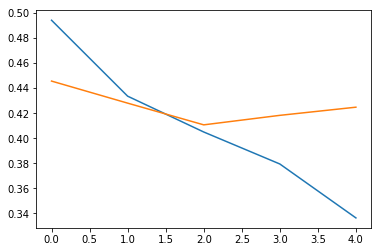

In [24]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['loss'])
plt.plot (hist.history['val_loss'])

## predict the test data

In [25]:
test_pred = model.predict([test_p, test_q, test_feature], batch_size=batch_size*4)

In [26]:
test_pred = np.squeeze(test_pred)
print(test_pred.shape)

(29997,)


## Write the array into csv file

In [27]:
res = pd.DataFrame({'id':test['id'], 'passage':test['passage'], 'query':test['query'], 'option':test['option'], 'label':test_pred})
res.to_csv('./result/test17_long.csv', index=False, encoding='utf-8_sig')

## check validation prediction result

In [28]:
val_pred = model.predict([valid_p, valid_q, valid_feature], batch_size=batch_size*4)
val_pred = np.squeeze(val_pred)
res = pd.DataFrame({'id':valid['id'], 'passage':valid['passage'], 'query':valid['query'], 'option':valid['option'], 'label':val_pred})
res.to_csv('./result/valid17_long.csv', index=False, encoding='utf-8_sig')